In [1]:
from feos import *
from feos.parameters import *

import si_units as si
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

colors = sns.color_palette("Dark2", 12)
sns.set_context("notebook")
sns.set_style("ticks")
sns.set_palette("Dark2")

# Validation of SAFT-VR Mie implementation

In this notebook, we reproduce some of the figures presented in the original [publication of Lafitte et al. (2013)](https://doi.org/10.1063/1.4819786).

# Phase diagrams of LJ and Mie fluids without chain contribution

In [2]:
exponents6 = [
    (8, 6),
    (10, 6),
    (12, 6),
    (15, 6),
    (20, 6),
    (36, 6)
]

other_exponents = [
    (12, 6),
    (14, 7),
    (18, 9),
    (24, 12)
]

def sample_exponents(exponents, npoints):
    to_reduced_density = si.MOL / si.METER**3 * si.NAV * si.ANGSTROM**3
    to_reduced_pressure = si.PASCAL * si.ANGSTROM**3 / si.KB / si.KELVIN
    
    result = {}
    for (lr, la) in exponents:
        record = PureRecord(Identifier(), 0, m=1.0, sigma=1.0, epsilon_k=1.0, lr=lr, la=la)    
        eos = EquationOfState.saftvrmie(Parameters.new_pure(record))
        cp = State.critical_point(eos)
        dia = PhaseDiagram.pure(eos, 0.3 * cp.temperature, npoints)
        df = pd.DataFrame(dia.to_dict(Contributions.Residual))
        df['density liquid'] *= to_reduced_density
        df['density vapor'] *= to_reduced_density
        df['pressure'] *= to_reduced_pressure
        result.update({(lr, la): df})
    return result

In [3]:
%%time
diagrams6 = sample_exponents(exponents6, 250)
other_diagrams= sample_exponents(other_exponents, 250)

CPU times: user 214 ms, sys: 3.95 ms, total: 218 ms
Wall time: 217 ms


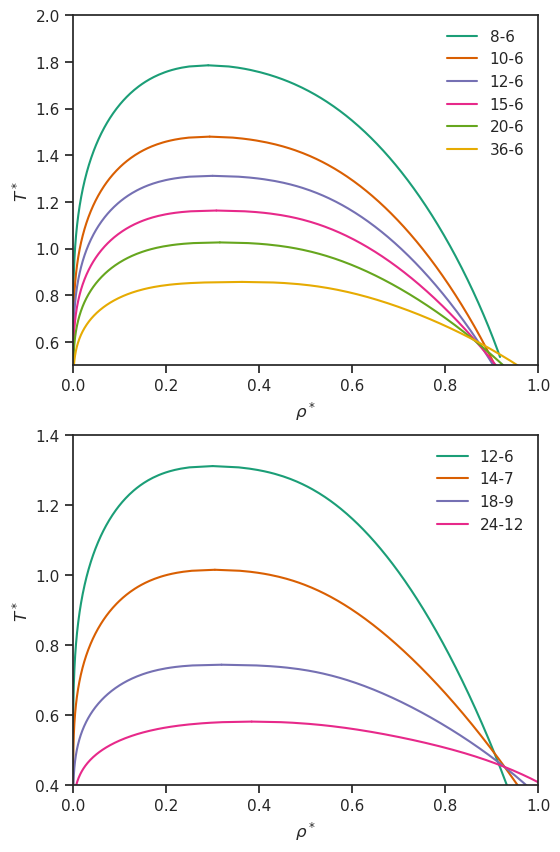

In [4]:
fig, ax = plt.subplots(2, 1, figsize=(6, 10))

for i, (e, data) in enumerate(diagrams6.items()):
    color = colors[i]
    sns.lineplot(data=data, ax=ax[0], x='density vapor', y='temperature', color=color, label=f"{e[0]}-{e[1]}")
    sns.lineplot(data=data, ax=ax[0], x='density liquid', y='temperature', color=color)

ax[0].set_ylim(0.5, 2.0)
ax[0].set_xlim(0., 1.)
ax[0].legend(frameon=False);
ax[0].set_xlabel(r"$\rho^*$")
ax[0].set_ylabel(r"$T^*$")

for i, (e, data) in enumerate(other_diagrams.items()):
    color = colors[i]
    sns.lineplot(data=data, ax=ax[1], x='density vapor', y='temperature', color=color, label=f"{e[0]}-{e[1]}")
    sns.lineplot(data=data, ax=ax[1], x='density liquid', y='temperature', color=color)

ax[1].set_ylim(0.4, 1.4)
ax[1].set_xlim(0., 1.)
ax[1].set_xlabel(r"$\rho^*$")
ax[1].set_ylabel(r"$T^*$")
ax[1].legend(frameon=False);

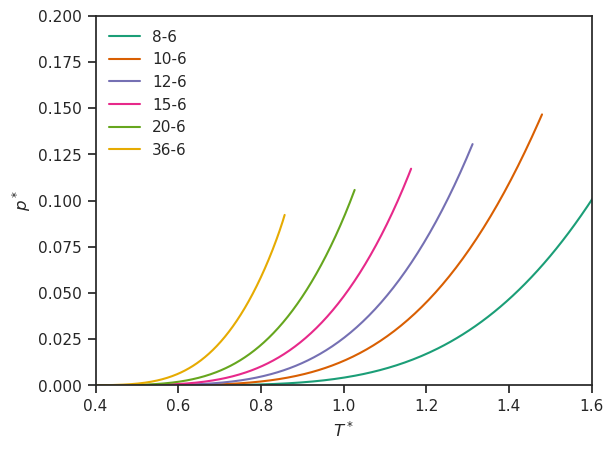

In [5]:
fig, ax = plt.subplots(1, 1)
for i, (e, data) in enumerate(diagrams6.items()):
    color = colors[i]
    sns.lineplot(data=data, ax=ax, y='pressure', x='temperature', color=color, label=f"{e[0]}-{e[1]}")

ax.set_ylim(0.0, 0.2)
ax.set_xlim(0.4, 1.6)
ax.legend(frameon=False)
ax.set_ylabel(r"$p^*$")
ax.set_xlabel(r"$T^*$");

# Lennard-Jones chains

In [6]:
def sample_chains(inputs, npoints):
    """Inputs: List[(m, lr, la)]"""
    to_reduced_density = si.MOL / si.METER**3 * si.NAV * si.ANGSTROM**3
    to_reduced_pressure = si.PASCAL * si.ANGSTROM**3 / si.KB / si.KELVIN
    
    result = {}
    for (m, lr, la) in inputs:
        record = PureRecord(Identifier(), 0, m=m, sigma=1.0, epsilon_k=1.0, lr=lr, la=la)    
        eos = EquationOfState.saftvrmie(Parameters.new_pure(record))
        cp = State.critical_point(eos)
        try:
            dia = PhaseDiagram.pure(eos, 0.4 * cp.temperature, npoints)
            df = pd.DataFrame(dia.to_dict(Contributions.Residual))
            df['density liquid'] *= to_reduced_density * m
            df['density vapor'] *= to_reduced_density * m
            df['pressure'] *= to_reduced_pressure
        except:
            dia = PhaseDiagram.pure(eos, 0.8 * cp.temperature, npoints)
            df = pd.DataFrame(dia.to_dict(Contributions.Residual))
            df['density liquid'] *= to_reduced_density * m
            df['density vapor'] *= to_reduced_density * m
            df['pressure'] *= to_reduced_pressure
        result.update({(m, lr, la): df})
    return result

In [7]:
lj_chains_input = [
    (1, 12, 6),
    (2, 12, 6),
    (4, 12, 6),
    (8, 12, 6)
]

In [8]:
lj_chains = sample_chains(lj_chains_input, 250)

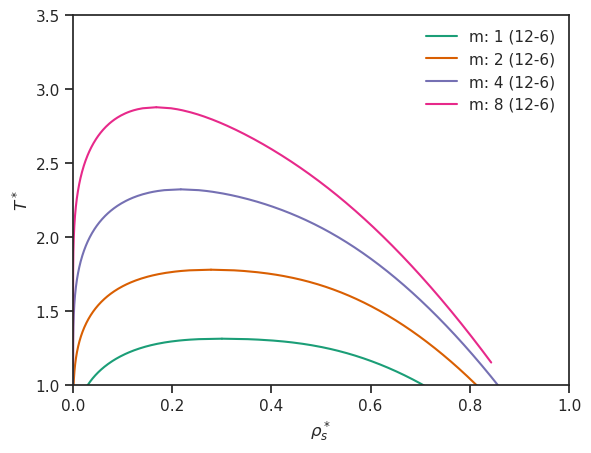

In [9]:
fig, ax = plt.subplots(1, 1)

for i, (e, data) in enumerate(lj_chains.items()):
    color = colors[i]
    sns.lineplot(data=data, ax=ax, x='density vapor', y='temperature', color=color, 
                 label=f"m: {e[0]} ({e[1]}-{e[2]})")
    sns.lineplot(data=data, ax=ax, x='density liquid', y='temperature', color=color)

ax.set_ylim(1.0, 3.5)
ax.set_xlim(0., 1.)
ax.legend(frameon=False);
ax.set_xlabel(r"$\rho_s^*$")
ax.set_ylabel(r"$T^*$");

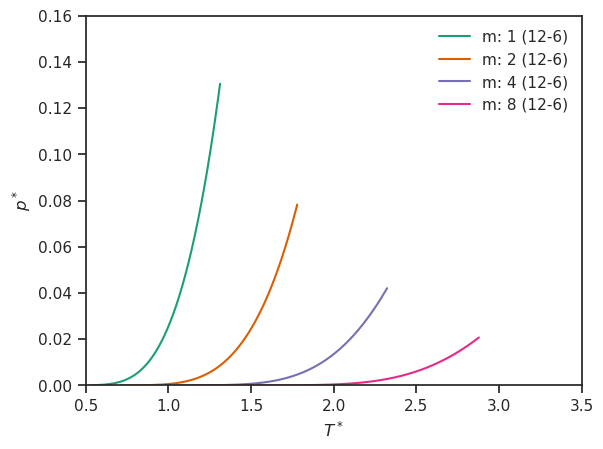

In [10]:
fig, ax = plt.subplots(1, 1)
for i, (e, data) in enumerate(lj_chains.items()):
    color = colors[i]
    sns.lineplot(data=data, ax=ax, y='pressure', x='temperature', color=color, label=f"m: {e[0]} ({e[1]}-{e[2]})")

ax.set_ylim(0.0, 0.16)
ax.set_xlim(0.5, 3.5)
ax.legend(frameon=False)
ax.set_ylabel(r"$p^*$")
ax.set_xlabel(r"$T^*$");

# Long LJ chains

In [11]:
lj_long_chains_input = [
    (1, 12, 6),
    (2, 12, 6),
    (4, 12, 6),
    (8, 12, 6),
    (20, 12, 6),
    (50, 12, 6),
    (100, 12, 6)
]

In [12]:
lj_long_chains = sample_chains(lj_long_chains_input, 250)

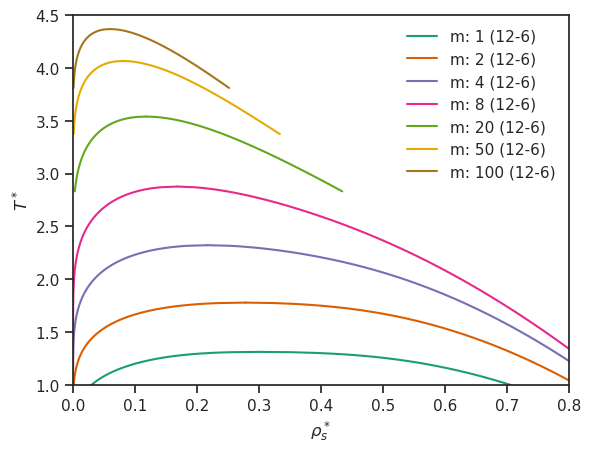

In [13]:
fig, ax = plt.subplots(1, 1)

for i, (e, data) in enumerate(lj_long_chains.items()):
    color = colors[i]
    sns.lineplot(data=data, ax=ax, x='density vapor', y='temperature', color=color, 
                 label=f"m: {e[0]} ({e[1]}-{e[2]})")
    sns.lineplot(data=data, ax=ax, x='density liquid', y='temperature', color=color)

ax.set_ylim(1.0, 4.5)
ax.set_xlim(0., 0.8)
ax.legend(frameon=False);
ax.set_xlabel(r"$\rho_s^*$")
ax.set_ylabel(r"$T^*$");

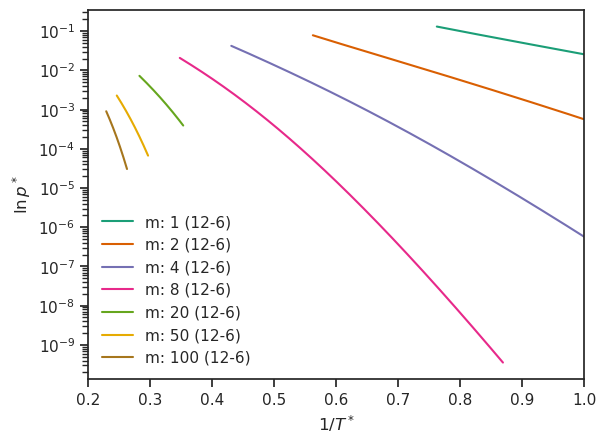

In [14]:
fig, ax = plt.subplots(1, 1)
for i, (e, data) in enumerate(lj_long_chains.items()):
    color = colors[i]
    sns.lineplot(data=data, ax=ax, y='pressure', x=1/data.temperature, color=color, label=f"m: {e[0]} ({e[1]}-{e[2]})")

#ax.set_ylim(0.0, 0.16)
ax.set_xlim(0.2, 1.0)
ax.legend(frameon=False)
ax.set_yscale("log")
ax.set_ylabel(r"$\ln p^*$")
ax.set_xlabel(r"$1 / T^*$");

# Associating LJ sites ($r^c_{ab} = 0.2 \sigma$, $r^d_{ab} = 0.4 \sigma$)

- Note: $r^d_{ab} = 0.4 \sigma$ is set as constant that cannot be changed.

In [15]:
def sample_association(inputs, npoints):
    """Inputs: List[(lr, la, eps_k_ab)]"""
    to_reduced_density = si.MOL / si.METER**3 * si.NAV * si.ANGSTROM**3
    to_reduced_pressure = si.PASCAL * si.ANGSTROM**3 / si.KB / si.KELVIN
    
    result = {}
    for (lr, la, eps_k_ab) in inputs:
        record = PureRecord(Identifier(), 0, m=1.0, sigma=1.0, epsilon_k=1.0, lr=lr, la=la, association_sites=[{"rc_ab": 0.2, "epsilon_k_ab": eps_k_ab, "na": 1.0, "nb": 1.0}])    
        eos = EquationOfState.saftvrmie(Parameters.new_pure(record))
        cp = State.critical_point(eos)
        dia = PhaseDiagram.pure(eos, 0.6 * cp.temperature, npoints)
        df = pd.DataFrame(dia.to_dict(Contributions.Residual))
        df['density liquid'] *= to_reduced_density
        df['density vapor'] *= to_reduced_density
        df['pressure'] *= to_reduced_pressure
        result.update({(lr, la, eps_k_ab): df})
    return result

In [16]:
assoc_inputs = [
    (12, 6, 10),
    (12, 6, 20),
]

In [17]:
lj_assoc = sample_association(assoc_inputs, 250)

<>:6: SyntaxWarning: invalid escape sequence '\e'
<>:6: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_996906/2770306470.py:6: SyntaxWarning: invalid escape sequence '\e'
  label=f"$\epsilon$: {e[2]} ({e[0]}-{e[1]})")


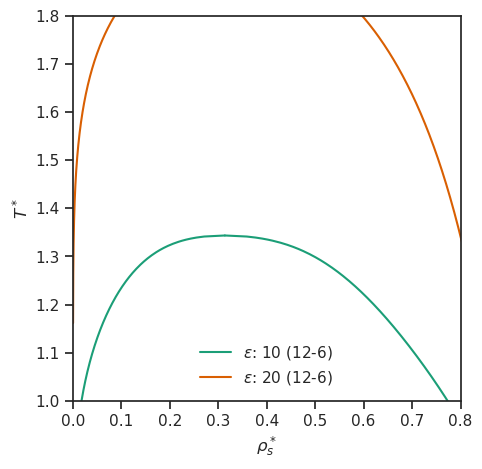

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))

for i, (e, data) in enumerate(lj_assoc.items()):
    color = colors[i]
    sns.lineplot(data=data, ax=ax, x='density vapor', y='temperature', color=color, 
                 label=f"$\epsilon$: {e[2]} ({e[0]}-{e[1]})")
    sns.lineplot(data=data, ax=ax, x='density liquid', y='temperature', color=color)

ax.set_ylim(1.0, 1.8)
ax.set_xlim(0., 0.8)
ax.legend(frameon=False);
ax.set_xlabel(r"$\rho_s^*$")
ax.set_ylabel(r"$T^*$");

# Compare critical data

In [19]:
critical_data = pd.read_csv("lafitte_critical_data.csv")
path = "../../parameters/saftvrmie/lafitte2013.json"

result = [] 
for _, row in critical_data.iterrows():
    p = Parameters.from_json([row.substance], path)
    eos = EquationOfState.saftvrmie(p)
    cp = State.critical_point(eos)
    try:
        cp.is_stable()
    except:
        cp = State.critical_point(eos, initial_temperature=600*si.KELVIN)
        cp.is_stable()
    tc = row.tc * si.KELVIN
    pc = row.pc * si.MEGA * si.PASCAL
    rhoc = row.rhoc * si.KILOGRAM / si.METER**3
    tce = row.tc_exp * si.KELVIN
    pce = row.pc_exp * si.MEGA * si.PASCAL
    rhoce = row.rhoc_exp * si.KILOGRAM / si.METER**3
    result.append(
        {
            "substance": row.substance,
            r"$\Delta T_c$ / %": (tc - cp.temperature) / tc * 100,
            r"$\Delta p_c$ / %": (pc - cp.pressure()) / pc * 100,
            r"$\Delta \rho_c$ / %": (rhoc - cp.mass_density()) / rhoc * 100,
            #r"$\Delta T_c^\text{exp}$ / %": (tce - cp.temperature) / tc * 100,
            #r"$\Delta p_c^\text{exp}$ / %": (pce - cp.pressure()) / pc * 100,
            #r"$\Delta \rho_c^\text{exp}$ / %": (rhoce - cp.mass_density()) / rhoc * 100,
        }
    )

In [20]:
pd.DataFrame(result)

,substance,$\Delta T_c$ / %,$\Delta p_c$ / %,$\Delta \rho_c$ / %
0,methane,0.074235,0.349624,0.408159
1,ethane,0.063685,0.303040,0.262340
2,propane,0.054626,0.218771,0.244391
3,n-butane,0.049322,0.322633,0.376631
4,pentane,0.041264,0.372420,0.452599
5,hexane,0.032569,0.425717,0.466502
6,heptane,0.021799,0.236802,0.516342
7,octane,0.013382,0.396097,0.520532
8,nonane,0.009823,0.204764,0.479280
9,decane,0.006019,0.236239,0.470530


# Binary Phase Diagrams of Ethane + n-Decane

In [21]:
p.pure_records[0].__class__

PureRecord

In [22]:
path = "../../parameters/saftvrmie/lafitte2013.json"
p = Parameters.from_json(["ethane", "decane"], path)
p = Parameters.new_binary(p.pure_records, k_ij=-0.0222)
p

|component|molarweight|m|sigma|epsilon_k|lr|la|
|-|-|-|-|-|-|-|
|ethane|30.047|1.4373|3.7257|206.12|12.4|6.0|
|decane|142.172|2.9976|4.589|400.79|18.885|6.0|

|component 1|component 2|k_ij|
|-|-|-|
|ethane|decane|-0.0222|

In [23]:
eos = EquationOfState.saftvrmie(p)

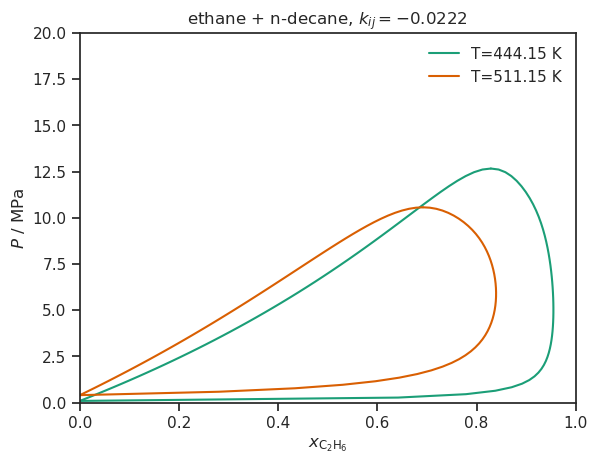

In [24]:
for i, t in enumerate([444.15*si.KELVIN, 511.15*si.KELVIN]):
    color = colors[i]
    dia = PhaseDiagram.binary_vle(eos, t, npoints=50)
    df = pd.DataFrame(dia.to_dict(Contributions.Residual))
    df.pressure = df.pressure * (si.PASCAL / si.MEGA / si.PASCAL)
    sns.lineplot(data=df, x="x0", y="pressure", sort=False, color=color)
    sns.lineplot(data=df, x="y0", y="pressure", sort=False, color=color, label=f"T={t}")

plt.title("ethane + n-decane, $k_{ij} = -0.0222$")
plt.legend(frameon=False)
plt.xlabel(r"$x_\mathrm{C_2H_6}$")
plt.ylabel("$P$ / MPa")
plt.xlim(0, 1)
plt.ylim(0, 20);